## MiniMarket-v1 EDA ##

This notebook goes through the historical market data that the MiniMarket-v1 environment is based on. The data in this notebook was pulled from the Federal Reserve Economic Data (FRED) database, a database maintained the Federal Reserve Bank of St. Louis. This data is available on the FRED website and via their publicly available API. The mechanics of the environment are designed based on OpenAI Gym's environment, which you can check out here: https://gym.openai.com/.

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

from marketenv import make_env, describe_env, MultiRegimeGBM, log_returns

%matplotlib inline

To start, we'll take a look at the environment's description.

In [4]:
describe_env('MiniMarket-v1')

MiniMarket-v1
MiniMarket-v1 is a small, long only stock market environment.
There are four tradable assets, which are simulated using
Geometric Brownian motion (GBM), and zero non-tradable data series.
At the beginning of each episode, an agent has $10,000 with which
to trade, and no commissions are charged when trading.

Observation Space: 
Vector of floats shape (9, )
The first item is the current cash balance.
The second through fifth items are the current number of shares
owned for each tradable asset.
The last four items are the current prices for each tradable asset.

Action Space:
Vector of integers shape (4, )
An agent cannot sell more shares than it owns and cannot purchase
more shares than it has cash available for.

Reward Range:
(-inf, inf)
The reward at each time step is the change in current portfolio
value, which is calculated as:
portfolio_value = cash_balance + np.dot(positions, current_prices)


The MiniMarket-v1 environment has four simulated tradable securities. The returns are simulated using Geometric Brownian motion (GBM), which is commonly used to simulate stock prices. You can read more about GBM here: https://en.wikipedia.org/wiki/Geometric_Brownian_motion

The four securities are loosely based on the following data series.

In [2]:
meta_data = pd.read_csv('./mini_market_data/market_meta_data.csv')
meta_data

,id,title,last_updated,popularity,frequency,frequency_short,observation_start,observation_end,seasonal_adjustment,seasonal_adjustment_short,units,units_short,notes,realtime_start,realtime_end
0,WILLLRGCAP,Wilshire US Large-Cap Total Market Index,2019-10-23 07:31:02-05,21,Daily,D,1978-06-30,2019-10-22,Not Seasonally Adjusted,NSA,Index,Index,The total market indexes are total market retu...,2019-10-23,2019-10-23
1,WILLSMLCAP,Wilshire US Small-Cap Total Market Index,2019-10-23 07:32:02-05,24,Daily,D,1978-06-30,2019-10-22,Not Seasonally Adjusted,NSA,Index,Index,The total market indexes are total market retu...,2019-10-23,2019-10-23
2,BAMLCC4A0710YTRIV,ICE BofAML US Corporate 7-10yr Total Return In...,2019-10-23 07:58:03-05,29,"Daily, Close",D,1992-06-30,2019-10-22,Not Seasonally Adjusted,NSA,Index,Index,This data represents the ICE BofAML US Corpora...,2019-10-23,2019-10-23
3,VIXCLS,CBOE Volatility Index: VIX,2019-10-23 08:36:02-05,74,"Daily, Close",D,1990-01-02,2019-10-22,Not Seasonally Adjusted,NSA,Index,Index,VIX measures market expectation of near term v...,2019-10-23,2019-10-23


While these indices are not directly tradable, there are index funds that track these indices, and, for the environment, we are primarily concerned with estimating historical returns, correlations, etc., which can be used for the model of the market.

Next, we'll take a look at the daily values for these data series.

In [3]:
data = pd.read_csv('./mini_market_data/historical_data.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date', drop = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7126 entries, 1992-06-30 to 2019-10-22
Data columns (total 4 columns):
WILLLRGCAP           7126 non-null float64
WILLSMLCAP           7126 non-null float64
BAMLCC4A0710YTRIV    7126 non-null float64
VIXCLS               7126 non-null float64
dtypes: float64(4)
memory usage: 278.4 KB


In [4]:
data.head()

,WILLLRGCAP,WILLSMLCAP,BAMLCC4A0710YTRIV,VIXCLS
date,,,,
1992-06-30,7414.6,7516.25,100.00,13.35
1992-07-01,7414.6,7516.25,100.17,13.34
1992-07-02,7414.6,7516.25,101.08,13.88
1992-07-03,7414.6,7516.25,101.08,13.88
1992-07-06,7414.6,7516.25,101.32,14.87


In [5]:
data.tail()

,WILLLRGCAP,WILLSMLCAP,BAMLCC4A0710YTRIV,VIXCLS
date,,,,
2019-10-16,94102.70,118929.89,582.05,13.68
2019-10-17,94398.84,120086.78,582.27,13.79
2019-10-18,94021.43,119715.94,583.00,14.25
2019-10-21,94682.86,120765.80,581.96,14.00
2019-10-22,94347.46,120770.02,583.47,14.46


Because the two Wilshire indices do not have true daily values until 1999, only data after 1999 was used, resulting in about 20 years of data.

In [6]:
data = data.loc['1999-01-01':, :]

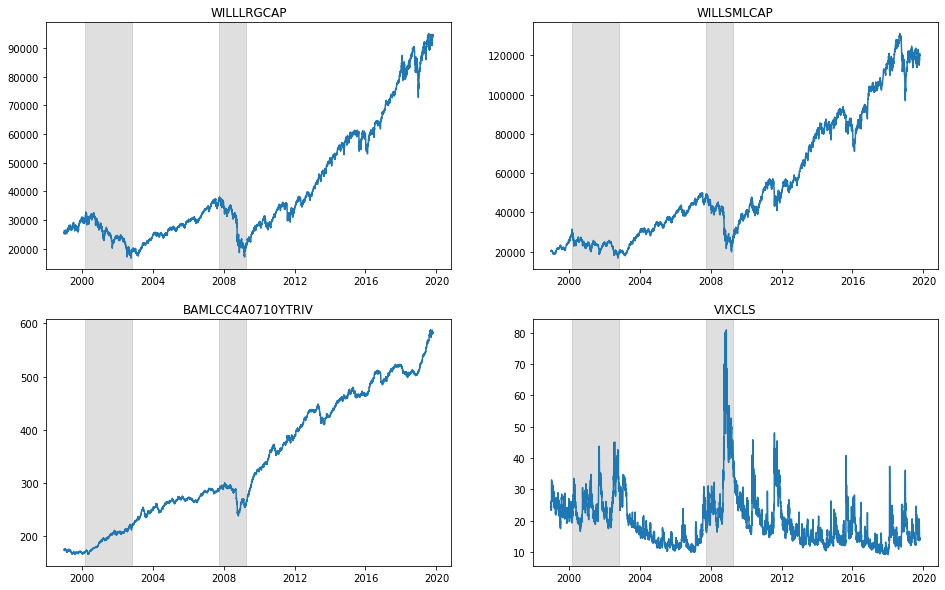

In [8]:
m = 2
n = 2
x_axis = data.index

fig, ax = plt.subplots(m, n, figsize = (16, 10))

for i in range(m):
    for j in range(n):
        index = i * n + j
        series_id = data.columns[index]
        ax[i][j].title.set_text(series_id)
        ax[i][j].plot(x_axis, data.iloc[:, index].values)
        
        ax[i][j].axvspan('2000-03-01', '2002-10-31', alpha = 0.25, color = 'grey', label = 'Bear Market')
        ax[i][j].axvspan('2007-10-01', '2009-03-31', alpha = 0.25, color = 'grey')

plt.show()

The data series are plotted above. The plots are also overlaid with the time periods for the two bear markets experienced during this 20-year period. Since stocks and other securities generally behave differently during bear markets and periods of high volatility, the data was split into two different regimes: a bull market regime and a bear market regime.

In [9]:
data.loc['2000-03-01':'2002-10-31', 'regime'] = 1
data.loc['2007-10-01':'2009-03-31', 'regime'] = 1
data['regime'] = data['regime'].fillna(0).astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5428 entries, 1999-01-01 to 2019-10-22
Data columns (total 5 columns):
WILLLRGCAP           5428 non-null float64
WILLSMLCAP           5428 non-null float64
BAMLCC4A0710YTRIV    5428 non-null float64
VIXCLS               5428 non-null float64
regime               5428 non-null int32
dtypes: float64(4), int32(1)
memory usage: 393.2 KB


While the the raw time series show what has occured over the historical time period, the return distributions are more interesting. We'll take a look at the historical return distributions next.

In [10]:
def plot_histogram(ax, data, bins = 100, density = True, alpha = 1.0, label = None):
    mean = np.mean(data)
    std = np.std(data)

    ax.hist(data, bins = bins, density = density, alpha = alpha, label = label)

    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 500)
    pdf = stats.norm.pdf(x, mean, std)
    ax.plot(x, pdf, linewidth = 2, label = 'Fit Normal, mu = {:.2f}, sigma = {:.2f}'.format(mean, std))

In [11]:
offset = 1
growth_rates = log_returns(data.loc[:, data.columns.drop('regime')], day_offset = offset, fill = True)
growth_rates.tail()

,WILLLRGCAP,WILLSMLCAP,BAMLCC4A0710YTRIV,VIXCLS
2019-10-16,-0.002484,0.000472,0.002133,0.010287
2019-10-17,0.003142,0.009680,0.000378,0.008009
2019-10-18,-0.004006,-0.003093,0.001253,0.032813
2019-10-21,0.007010,0.008731,-0.001785,-0.017700
2019-10-22,-0.003549,0.000035,0.002591,0.032329


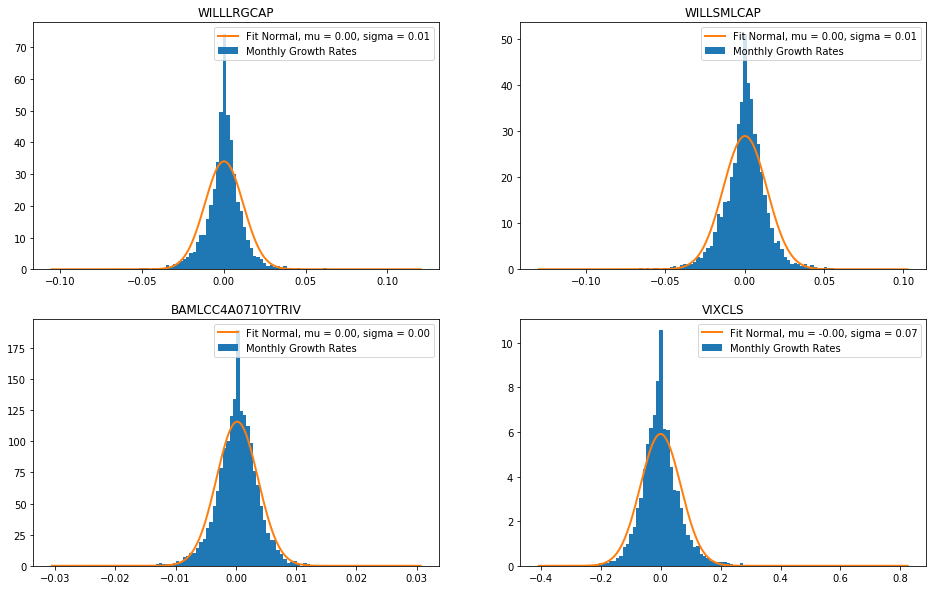

In [12]:
m = 2
n = 2

fig, ax = plt.subplots(m, n, figsize = (16, 10))

for i in range(m):
    for j in range(n):
        index = i * n + j
        series_id = growth_rates.columns[index]
        ax[i][j].title.set_text(series_id)
        
        plot_histogram(ax[i][j], growth_rates[series_id].values, label = 'Monthly Growth Rates')
        
        ax[i][j].legend(loc = 'upper right')
        
plt.show()

While the daily returns are close to normal, there are a few key differences:
1. The distributions are more peaked.
2. The distributions have fatter tails (higher kurtosis).

It is well known that the normal distribution is not a perfect model of stock price returns. While daily returns are closely centered around zero, which we would expect as daily prices generally do not fluctuate as much, the annual return distributions are more complex.

In [13]:
offset = 365
growth_rates = log_returns(data.loc[:, data.columns.drop('regime')], day_offset = offset, fill = True)
growth_rates.tail()

,WILLLRGCAP,WILLSMLCAP,BAMLCC4A0710YTRIV,VIXCLS
2019-10-16,0.081504,-0.017733,0.141602,-0.253100
2019-10-17,0.085058,-0.004165,0.143664,-0.232527
2019-10-18,0.095591,0.010493,0.144877,-0.341971
2019-10-21,0.103220,0.029910,0.144917,-0.351160
2019-10-22,0.103970,0.033028,0.147290,-0.306182


In [14]:
growth_rates.loc['2000-03-01':'2002-10-31', 'regime'] = 1
growth_rates.loc['2007-10-01':'2009-03-31', 'regime'] = 1
growth_rates['regime'] = growth_rates['regime'].fillna(0).astype(int)
growth_rates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5167 entries, 2000-01-03 to 2019-10-22
Data columns (total 5 columns):
WILLLRGCAP           5167 non-null float64
WILLSMLCAP           5167 non-null float64
BAMLCC4A0710YTRIV    5167 non-null float64
VIXCLS               5167 non-null float64
regime               5167 non-null int32
dtypes: float64(4), int32(1)
memory usage: 382.0 KB


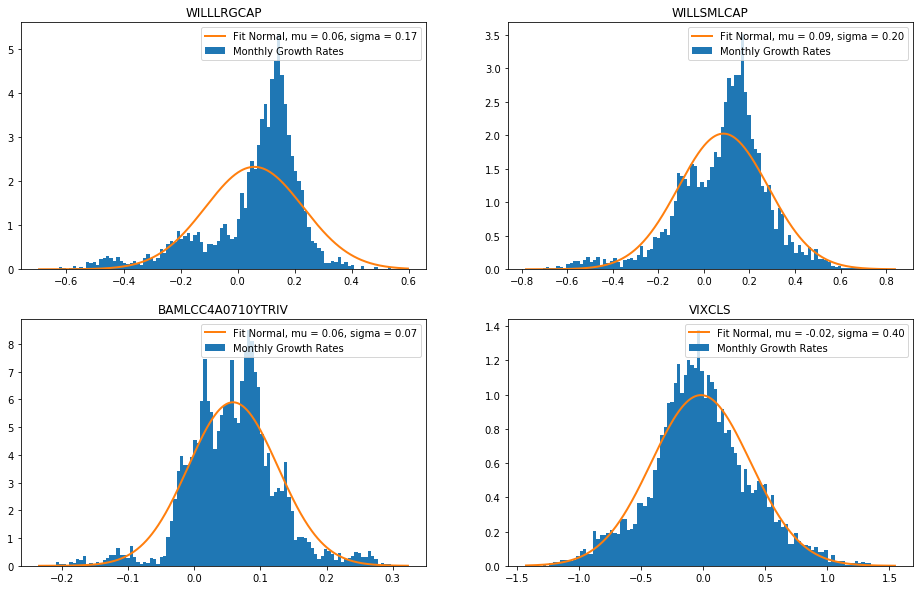

In [15]:
m = 2
n = 2

fig, ax = plt.subplots(m, n, figsize = (16, 10))

for i in range(m):
    for j in range(n):
        index = i * n + j
        series_id = growth_rates.columns[index]
        ax[i][j].title.set_text(series_id)
        
        plot_histogram(ax[i][j], growth_rates[series_id].values, label = 'Monthly Growth Rates')
        
        ax[i][j].legend(loc = 'upper right')
        
plt.show()

The annual return distributions are much further from normal - some are even slightly multimodal. Next, we'll plot the annual return distributions for each regime.

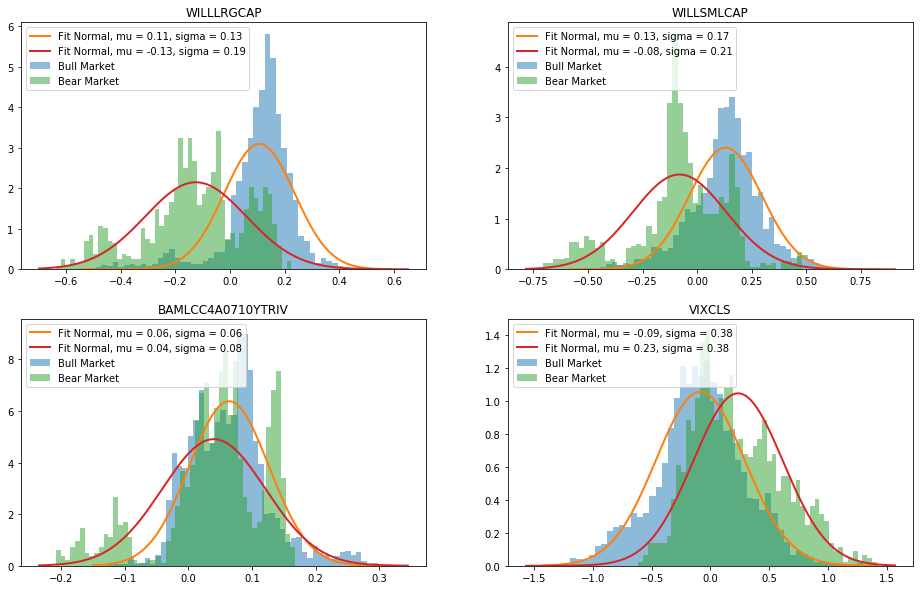

In [16]:
m = 2
n = 2

fig, ax = plt.subplots(m, n, figsize = (16, 10))

for i in range(m):
    for j in range(n):
        index = i * n + j
        series_id = growth_rates.columns[index]
        ax[i][j].title.set_text(series_id)
        
        plot_histogram(ax[i][j], growth_rates.loc[growth_rates['regime'] == 0, series_id].values, 
                       label = 'Bull Market', bins = 50, alpha = 0.5)
        plot_histogram(ax[i][j], growth_rates.loc[growth_rates['regime'] == 1, series_id].values, 
                       label = 'Bear Market', bins = 50, alpha = 0.5)
        
        ax[i][j].legend(loc = 'upper left')
        
plt.show()

As expected, the return distributions for each regime are quite different. The two equity indices have positive mean returns during the bull market and negative mean returns for the bear markets. The bond index has a positive mean return for both regimes, but lower positive returns and lower variance. Finally, the volatility index has a positive mean return for the bear market regime and a negative mean return for the bull market. As we'll see next, the equity indices and the volatility indices are negatively correlated.

In [17]:
def plot_correlation_heatmap(ax, data, annot = False):
    correlation_matrix = np.corrcoef(data.values.transpose())
    
    labels = data.columns
    sns.heatmap(correlation_matrix, ax = ax, cmap = sns.cm.rocket_r, linewidth = 0.25, 
                xticklabels = labels, yticklabels = labels, annot = annot)
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)

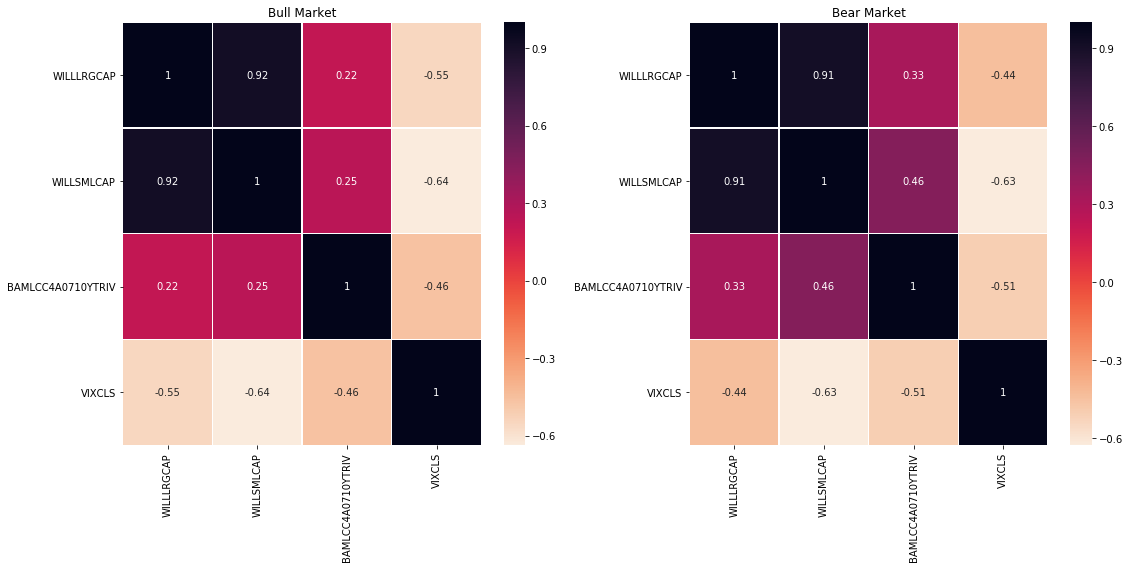

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))

ax[0].title.set_text('Bull Market')
plot_correlation_heatmap(ax[0], growth_rates.loc[growth_rates['regime'] == 0, data.columns.drop('regime')], annot = True)

ax[1].title.set_text('Bear Market')
plot_correlation_heatmap(ax[1], growth_rates.loc[growth_rates['regime'] == 1, data.columns.drop('regime')], annot = True)

plt.tight_layout()
plt.show()

The two correlation matrices above confirm the negative correlation between the volatility index and the other data series. The returns for the two equity indices are heavily correlated in both the bear and bull market regimes, but the bond index return and the equity index returns have relatively low correlation. So far, all results are consistent with the generally agreed upon style of these different asset returns.

One of the advantages of simulating GBM is that it is easy to incorporate correlation, which is vital for many portfolio management techniques.

The generic MarketEnv object takes as input a simulator object, which simulates the various data series for the environment. The simulator used for the MiniMarket-v1 environment is a two regime GBM model. The MultiRegimeGBM simulator has a method that we can use to estimate model parameters with data.

In [19]:
simulator = MultiRegimeGBM(lambda: 1.0, episode_len = 500)
simulator.fit_params(data, return_period = 'annual', regimes = 'last')

'function' object has no attribute 'seed'


C:\Users\pspalding\Desktop\Machine Learning Resources\DeepRL\marketenv\environments\simulators.py:87: UserWarning: init_prices object does not have a seed method
  warnings.warn('init_prices object does not have a seed method')


The current regime at any point in the simulation is determined by a Markov chain, which is fit using the tagged regime data. The return distributions were estimated using the mean returns, return standard deviations, and correlation matrix for the four time series. Let's take a quick look.

In [20]:
simulator.init_probs

array([0.79937362, 0.20062638])

The Markov chain fit using the historical data has a 80% chance to start in a bull market and a 20% chance to start in a bear market. The daily probability of switching from one regime to the other is determined from the trasition probaility matrix.

In [21]:
simulator.transition_probs

array([[9.99538958e-01, 4.61041955e-04],
       [1.83654729e-03, 9.98163453e-01]])

Using this data, we can quickly calculate the probability of switching regimes at least once during an episode with 500 time steps.

In [22]:
c1 = 1 - simulator.transition_probs[0, 0]**simulator.episode_len
c2 = 1 - simulator.transition_probs[1, 1]**simulator.episode_len
ps = simulator.init_probs[0] * c1 + simulator.init_probs[1] * c2
print('Probability of switching regimes at least once: {:0.2f}'.format(ps))

Probability of switching regimes at least once: 0.29


Now, we can look at a few simulations! The top graph shows the simulated time series while the bottom shows the current regime the environment is in.

In [23]:
def plot_simulation(simulation, regime, labels):
    assert (simulation.shape[1] == len(labels))
    
    top = plt.subplot2grid((5, 5), (0, 0), rowspan = 4, colspan = 5)
    bottom = plt.subplot2grid((5, 5), (4, 0), rowspan = 1, colspan = 5)
    
    for i in range(simulation.shape[1]):
        top.plot(simulation[:, i], label = labels[i])
        
    bottom.plot(regime)
    
    return top, bottom

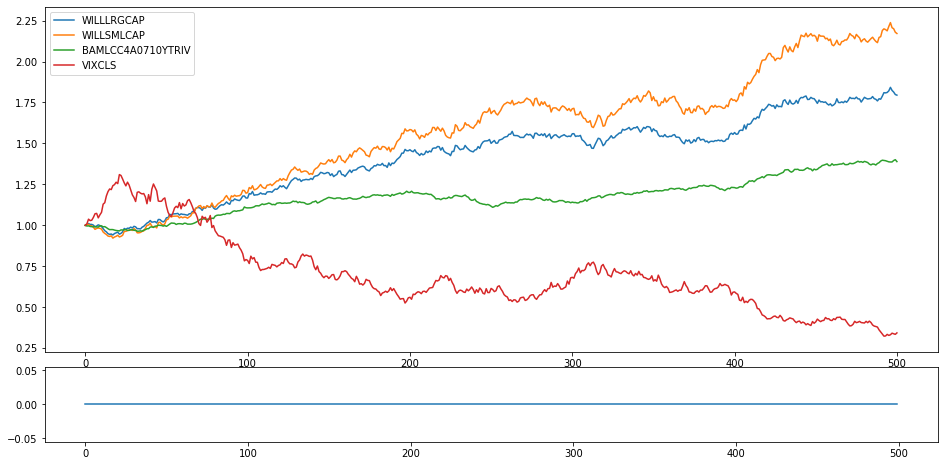

In [24]:
simulation, info = simulator.simulate()

fig = plt.figure(figsize = (16, 8))
plt.title('Simulation')
top, bottom = plot_simulation(simulation, info['regimes'], data.columns.drop(['regime']))
top.legend(loc = 'upper left')
plt.show()

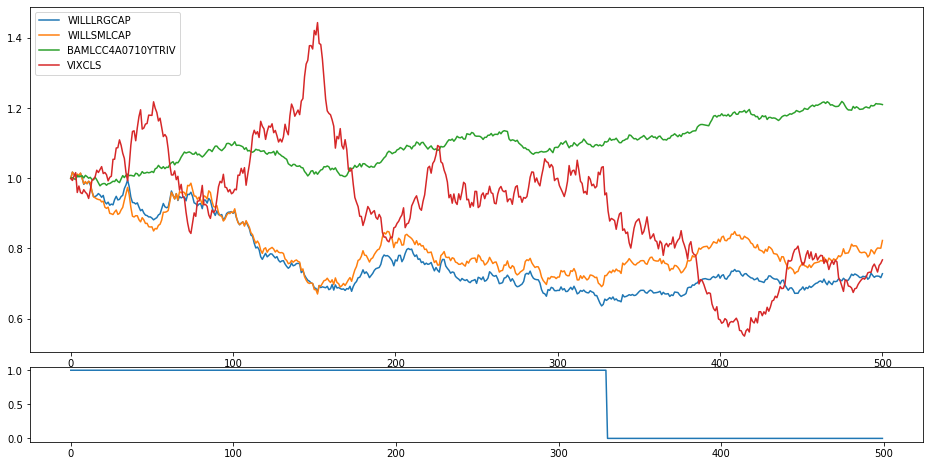

In [25]:
simulation, info = simulator.simulate()

fig = plt.figure(figsize = (16, 8))
plt.title('Simulation')
top, bottom = plot_simulation(simulation, info['regimes'], data.columns.drop(['regime']))
top.legend(loc = 'upper left')
plt.show()

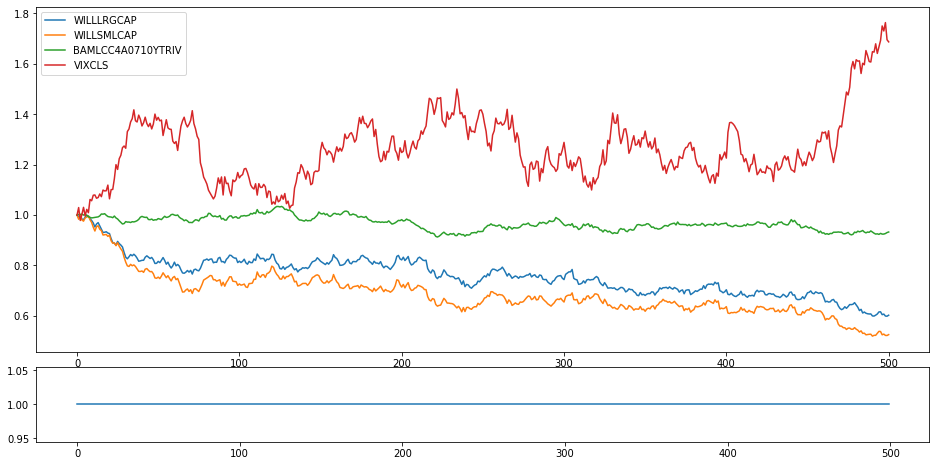

In [26]:
simulation, info = simulator.simulate()

fig = plt.figure(figsize = (16, 8))
plt.title('Simulation')
top, bottom = plot_simulation(simulation, info['regimes'], data.columns.drop(['regime']))
top.legend(loc = 'upper left')
plt.show()

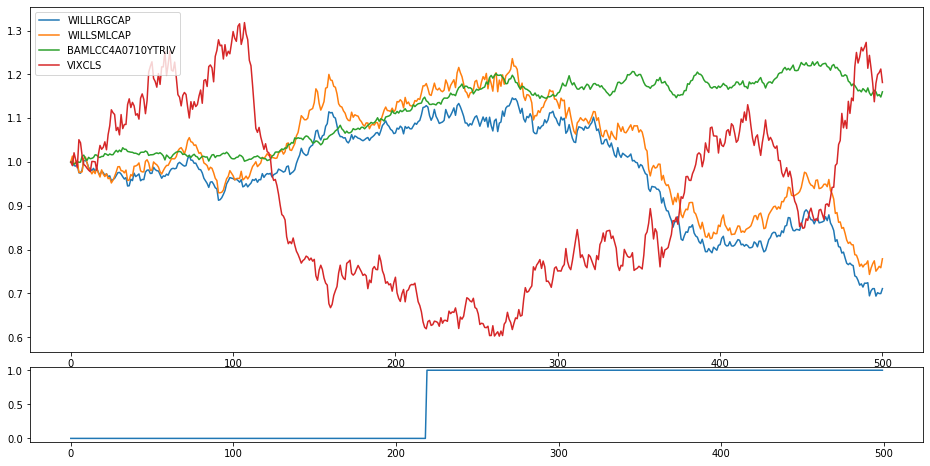

In [27]:
simulation, info = simulator.simulate()

fig = plt.figure(figsize = (16, 8))
plt.title('Simulation')
top, bottom = plot_simulation(simulation, info['regimes'], data.columns.drop(['regime']))
top.legend(loc = 'upper left')
plt.show()

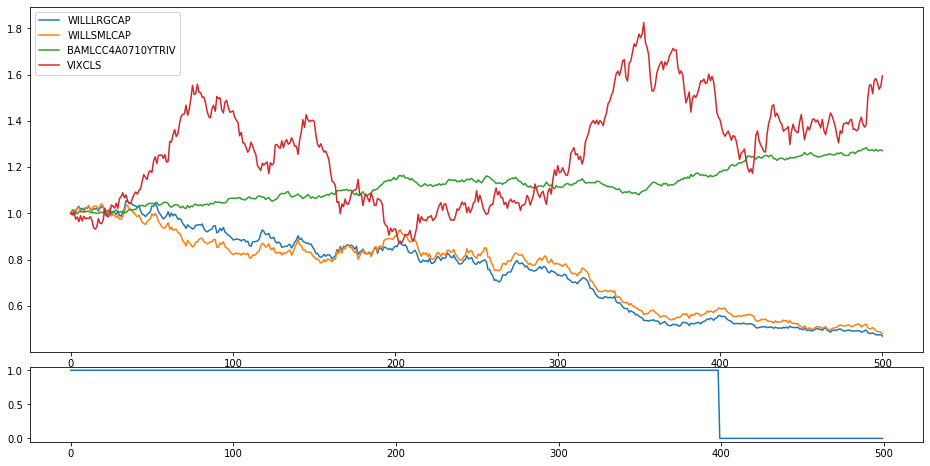

In [28]:
simulation, info = simulator.simulate()

fig = plt.figure(figsize = (16, 8))
plt.title('Simulation')
top, bottom = plot_simulation(simulation, info['regimes'], data.columns.drop(['regime']))
top.legend(loc = 'upper left')
plt.show()

Finally, let's look initialize a MiniMarket-v1 environment!

In [2]:
env = make_env('MiniMarket-v1', episode_len = 500)

In [3]:
simulator = env._simulator

print('Simulator Rarameters')
for i, regime in enumerate(simulator.regimes):
    print('Regime {}'.format(i))
    print('Mean:')
    print(regime.mu)
    print('Standard deviation:')
    print(regime.sigma)
    print('Correlation matrix:')
    print(regime.rho)
print('\nInitial probabilities:')
print(simulator.init_probs)
print('Transition probabilities')
print(simulator.transition_probs)

Simulator Rarameters
Regime 0
Mean:
[ 0.15  0.1   0.05 -0.05]
Standard deviation:
[0.15 0.2  0.04 0.35]
Correlation matrix:
[[ 1.    0.8   0.3  -0.35]
 [ 0.8   1.    0.3  -0.5 ]
 [ 0.3   0.3   1.   -0.35]
 [-0.35 -0.5  -0.35  1.  ]]
Regime 1
Mean:
[-0.125 -0.075  0.04   0.2  ]
Standard deviation:
[0.2   0.225 0.08  0.4  ]
Correlation matrix:
[[ 1.    0.9   0.35 -0.5 ]
 [ 0.9   1.    0.45 -0.65]
 [ 0.35  0.45  1.   -0.6 ]
 [-0.5  -0.65 -0.6   1.  ]]

Initial probabilities:
[0.8 0.2]
Transition probabilities
[[9.995e-01 5.000e-04]
 [2.000e-03 9.980e-01]]


The above parameters for the multi-regime GBM model are pretty consistent with the mean returns, standard deviations, correlations, and probabilities from the historical data above (most numbers were rounded for convenience). Lastly, we can look at a simulation from the environment by looking under the hood at the simulator object for the environment.

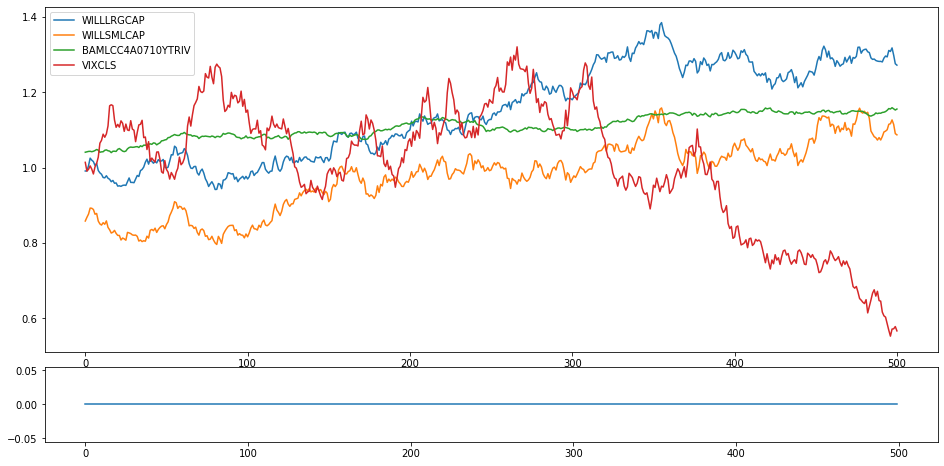

In [31]:
simulation, info = env._simulator.simulate()

fig = plt.figure(figsize = (16, 8))
plt.title('Simulation')
top, bottom = plot_simulation(simulation, info['regimes'], data.columns.drop(['regime']))
top.legend(loc = 'upper left')
plt.show()